In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
import gc

BASE = './'
else:
    BASE = '../input/godaddy-microbusiness-density-forecasting/'
    
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchvision import datasets, transforms, models
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Data prepocessing

In [3]:
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')

train.shape, test.shape, sub.shape

((122265, 7), (25080, 3), (25080, 2))

In [4]:
train["dcount"] = train.groupby(['cfips'])['row_id'].cumcount()
train['county_code'] = train['cfips'].apply(lambda x: str(x)[:-3])
train['state_code'] = train['cfips'].apply(lambda x: str(x)[-3:])

In [5]:
train = train[['county_code', 'state_code', 'dcount', 'microbusiness_density', 'cfips']]
train.head()

,county_code,state_code,dcount,microbusiness_density,cfips
0,1,001,0,3.007682,1001
1,1,001,1,2.884870,1001
2,1,001,2,3.055843,1001
3,1,001,3,2.993233,1001
4,1,001,4,2.993233,1001


In [6]:
train_pt = pd.pivot_table(train, index=['county_code', 'state_code', 'cfips'], columns=['dcount']).reset_index()
train_pt

county_code state_code cfips microbusiness_density                      \
dcount                                                  0         1         2   
0                1        001  1001              3.007682  2.884870  3.055843   
1                1        003  1003              7.239156  7.290936  7.425439   
2                1        005  1005              1.073138  0.995794  1.160149   
3                1        007  1007              1.310777  1.305176  1.254761   
4                1        009  1009              1.544148  1.575892  1.546415   
...            ...        ...   ...                   ...       ...       ...   
3130             9        007  9007              7.032581  6.923002  6.941015   
3131             9        009  9009              6.388350  6.256700  6.211010   
3132             9        011  9011              4.404949  4.377251  4.374019   
3133             9        013  9013              6.488734  6.367856  6.379944   
3134             9        015  9015              3.702548  3.754211  3.748830   

                                                ...                      \
dcount         3         4         5         6  ...        29        30   
0       2.993233  2.993233  2.969090  2.909326  ...  3.296781  3.334431   
1       7.426071  7.470274  7.413655  7.282522  ...  7.733397  7.823300   
2       1.000628  1.000628  1.027229  1.022314  ...  1.186629  1.206827   
3       1.254761  1.265965  1.253638  1.248041  ...  1.214165  1.236650   
4       1.573625  1.555485  1.573217  1.536999  ...  1.752923  1.777708   
...          ...       ...       ...       ...  ...       ...       ...   
3130    6.943266  6.918499  6.948894  6.869358  ...  6.900000  6.891045   
3131    6.299460  6.273833  6.277275  6.177921  ...  6.753906  6.806637   
3132    4.392946  4.381405  4.388145  4.304685  ...  4.601114  4.615542   
3133    6.347710  6.404925  6.320415  6.260864  ...  4.379989  4.400026   
3134    3.796188  3.887675  3.932530  3.955106  ...  3.524116  3.492040   

                                                                              \
dcount        31        32        33        34        35        36        37   
0       3.336785  3.372082  3.313253  3.346197  3.437971  3.423852  3.442677   
1       7.945311  7.979170  7.907365  8.507496  8.573463  8.491150  8.341701   
2       1.196728  1.191678  1.186629  1.191678  1.216926  1.196728  1.206827   
3       1.264755  1.253513  1.247892  1.275998  1.326588  1.292861  1.315346   
4       1.797986  1.764189  1.748417  1.773202  1.831783  1.836289  1.852060   
...          ...       ...       ...       ...       ...       ...       ...   
3130    6.926119  6.943284  6.840299  6.857463  6.909701  6.885075  6.889552   
3131    6.874601  7.074098  7.025469  7.016095  7.112914  7.049198  7.046268   
3132    4.636951  4.631366  4.581567  4.624385  4.704437  4.685820  4.704902   
3133    4.424069  4.443304  4.427275  4.444106  4.529862  4.476966  4.500208   
3134    3.519839  3.538016  3.524116  3.521978  3.574369  3.552985  3.567954   

                  
dcount        38  
0       3.463856  
1       8.359798  
2       1.232074  
3       1.287240  
4       1.831783  
...          ...  
3130    6.912686  
3131    7.033818  
3132    4.714211  
3133    4.492995  
3134    3.566885  

[3135 rows x 42 columns]

In [7]:
train_pt = train_pt.sort_values('cfips').drop(['cfips'], axis=1)

/tmp/ipykernel_1576664/1972351883.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train_pt = train_pt.sort_values('cfips').drop(['cfips'], axis=1)


#### Datasets

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, predict_borders=(4, 12), min_train_period=12, known_len=39,
                 dataset_len=10000, evaluation=False):
        self.data = data.copy()
        dic_county = {j:i for i, j in enumerate(data['county_code'].unique())}
        data['county_code'] = data['county_code'].replace(dic_county)
        dic_county = {j:i for i, j in enumerate(data['state_code'].unique())}
        data['state_code'] = data['state_code'].replace(dic_county)

        self.data_cats = data[['county_code', 'state_code']].values.copy()
        self.data_values = data['microbusiness_density'].astype('float32').values.copy()
        self.n_places = len(data)
        self.predict_borders = predict_borders
        self.min_train_period = min_train_period
        self.known_len = known_len
        self.len = dataset_len
        self.eval = evaluation
            
    def __getitem__(self, index):
        if (self.eval==True):
            np.random.seed(index+int(10e6)+42)
        else:
            np.random.seed(index)
            
        row = np.random.choice(self.n_places)
        predict_len = np.random.randint(self.predict_borders[0], self.predict_borders[1]+1)
        
        predict_from_max = self.known_len - predict_len # predict from (inclusively)
        predict_from_min = self.min_train_period
        predict_from = np.random.randint(predict_from_min, predict_from_max+1)
        
        train_from_max = predict_from - self.min_train_period
        train_from_min = 0
        train_from = np.random.randint(train_from_min, train_from_max+1)
        
        return self.data_cats[row, 0],\
               self.data_cats[row, 1],\
               self.data_values[row, train_from:predict_from],\
               self.data_values[row, predict_from:predict_from+predict_len],\
               row
    
        # return torch.Tensor(self.data_cats[row, 0]),\
        #        torch.Tensor(self.data_cats[row, 1]),\
        #        torch.Tensor(self.data_values[row, train_from:predict_from]),\
        #        torch.Tensor(self.data_values[row, predict_from:predict_from+predict_len]),\
        #        torch.Tensor(row)

    def __len__(self):
        return self.len
    
    # def __getshape__(self):
    #     return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [9]:
class CustomDataset_Test(Dataset):
    def __init__(self, data, predict_periods=8, train_periods=12, known_len=39):
        self.data = data.copy()
        dic_county = {j:i for i, j in enumerate(data['county_code'].unique())}
        data['county_code'] = data['county_code'].replace(dic_county)
        dic_county = {j:i for i, j in enumerate(data['state_code'].unique())}
        data['state_code'] = data['state_code'].replace(dic_county)

        self.data_cats = data[['county_code', 'state_code']].values.copy()
        self.data_values = data['microbusiness_density'].astype('float32').values.copy()
        self.predict_periods = predict_periods
        self.train_periods = train_periods
        self.known_len = known_len
        self.len = len(data)
        # np.random.seed(random_state)
            
    def __getitem__(self, index):
        row = index
        train_from = self.known_len - self.train_periods
        
        return self.data_cats[row, 0],\
               self.data_cats[row, 1],\
               self.data_values[row, train_from:],\
               -1,\
               row

    def __len__(self):
        return self.len
    
    # def __getshape__(self):
    #     return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [10]:
SOS_token = 0
# EOS_token = 1 # no need for EOS token - we always knew the length of target

MIN_PRED_LENGTH = 2
MAX_PRED_LENGTH = 8
MIN_TRAIN_PERIOD = 12
DATASET_TRAIN_LEN = 300000
DATASET_EVAL_LEN = 10000

MAX_LENGTH = 39
# -4+1

In [11]:
dataset_train = CustomDataset(train_pt,
                              predict_borders = (MIN_PRED_LENGTH, MAX_PRED_LENGTH),
                              min_train_period = MIN_TRAIN_PERIOD,
                              dataset_len = DATASET_TRAIN_LEN)

dataset_eval = CustomDataset(train_pt,
                             predict_borders = (2, 8),
                             min_train_period = MIN_TRAIN_PERIOD,
                             dataset_len = DATASET_EVAL_LEN,
                             evaluation = True)


dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, num_workers=8)
dataloader_eval = torch.utils.data.DataLoader(dataset_eval, batch_size=1, num_workers=8)

In [12]:
# dataset_test = CustomDataset_Test(train_pt, train_periods=MIN_TRAIN_PERIOD)
# dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, num_workers=8)

#### Classes & Functions

##### Simplified seq2seq model

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size_county, input_size_state, hidden_size, use_cats=False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.use_cats = use_cats

        self.embedding_county = nn.Embedding(input_size_county, 8)
        self.embedding_state = nn.Embedding(input_size_state, 16)
        
        if (self.use_cats==True):
            self.rnn = nn.RNN(1+8+16, hidden_size)
        else:
            self.rnn = nn.RNN(1, hidden_size)

    def forward(self, county, state, input, hidden):
        output = input.view(1, 1, -1)
        if (self.use_cats==True):
            embedded_county = self.embedding_county(county).view(1, 1, -1)
            embedded_state = self.embedding_state(state).view(1, 1, -1)
            output = torch.cat([embedded_county, embedded_state, output], dim=-1)
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size_county, input_size_state, hidden_size, output_size=1, use_cats=False):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.use_cats = use_cats

        self.embedding_county = nn.Embedding(input_size_county, 8)
        self.embedding_state = nn.Embedding(input_size_state, 16)
        
        if (self.use_cats==True):
            self.rnn = nn.RNN(1+8+16, hidden_size)
        else:
            self.rnn = nn.RNN(1, hidden_size)
            
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, county, state, input, hidden):

        output = input.view(1, 1, -1)
        if (self.use_cats==True):
            embedded_county = self.embedding_county(county).view(1, 1, -1)
            embedded_state = self.embedding_state(state).view(1, 1, -1)
            output = torch.cat([embedded_county, embedded_state, output], dim=-1)
            output = F.relu(output)
        
        output, hidden = self.rnn(output, hidden)
        output = self.out(output[0]) #!!!
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
teacher_forcing_ratio = 0.5

def train(county_tensor, state_tensor, input_tensor, target_tensor,
          encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            county_tensor, state_tensor, input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device, dtype=torch.float32)
    decoder_hidden = encoder_hidden # simple seq2seq model with only contex vector transmitting

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                county_tensor, state_tensor, decoder_input, decoder_hidden)
            
            loss += criterion(decoder_output.squeeze_(), target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                county_tensor, state_tensor, decoder_input, decoder_hidden)
            loss += criterion(decoder_output.squeeze_(), target_tensor[di])
            decoder_input = decoder_output

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
def evaluate(county_tensor, state_tensor, input_tensor, target_tensor,
             encoder, decoder, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden()
        
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        # input_length = len(input_tensor)
        # target_length = len(target_tensor)
        
        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                county_tensor, state_tensor, input_tensor[ei], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device, dtype=torch.float32)  # SOS
        decoder_hidden = encoder_hidden

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                county_tensor, state_tensor, decoder_input, decoder_hidden)
            loss += criterion(decoder_output.squeeze_(), target_tensor[di])
            decoder_input = decoder_output

    return loss.item() / target_length

In [17]:
def test(encoder, decoder, loader_test, max_length=MAX_LENGTH):
    with torch.no_grad():

        preds = torch.zeros(len(loader_test), max_length)
        
        row = 0
        for iter in tqdm(loader_test):
            county_tensor, state_tensor, input_tensor, target_tensor = \
                iter[0].squeeze_().to(device), iter[1].squeeze_().to(device), iter[2].squeeze_().to(device), iter[3].squeeze_().to(device)
        
            encoder_hidden = encoder.initHidden()
        
            input_length = input_tensor.size(0)
            target_length = max_length

            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(
                    county_tensor, state_tensor, input_tensor[ei], encoder_hidden)

            decoder_input = torch.tensor([[SOS_token]], device=device, dtype=torch.float32)  # SOS
            decoder_hidden = encoder_hidden

            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(
                    county_tensor, state_tensor, decoder_input, decoder_hidden)
                preds[row, di] = decoder_output
                decoder_input = decoder_output
            row += 1

    return preds

In [18]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [19]:
class SMAPE(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred: torch.Tensor, y: torch.Tensor) -> float:
        return 2*(y - y_pred).abs() / (y.abs() + y_pred.abs())
        
#         e = torch.abs(y.view_as(y_pred) - y_pred) / torch.abs(y.view_as(y_pred))
#         return 100.0 * torch.median(e)

In [20]:
def trainIters(encoder, decoder, loader_train, loader_eval, epochs=1,
               print_every=10000, plot_every=10000, learning_rate=0.001):
    
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # criterion = nn.L1Loss()
    criterion = SMAPE()
    
    for epoch in range(epochs):
        counter = 0
    
        for iter in tqdm(loader_train):
            county_tensor, state_tensor, input_tensor, target_tensor = \
            iter[0].squeeze_().to(device), iter[1].squeeze_().to(device), iter[2].squeeze_().to(device), iter[3].squeeze_().to(device)

            loss = train(county_tensor, state_tensor, input_tensor, target_tensor,
                         encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss
            counter +=1

            if counter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                
                for iter_eval in loader_eval:
                    county_tensor, state_tensor, input_tensor, target_tensor = \
                    iter_eval[0].squeeze_().to(device), iter_eval[1].squeeze_().to(device), iter_eval[2].squeeze_().to(device), iter_eval[3].squeeze_().to(device)
                
                    loss_eval = evaluate(county_tensor, state_tensor, input_tensor, target_tensor,
                                         encoder, decoder, criterion)

                print('train loss average..', print_loss_avg, '\n',
                      'eval loss average..', loss_eval, '\n',
                      'epoch..', epoch, 'progress..', counter/len(loader_train)*100)
                
                
                
#             if counter % plot_every == 0:
#                 plot_loss_avg = plot_loss_total / plot_every
#                 plot_losses.append(plot_loss_avg)
#                 plot_loss_total = 0

#         showPlot(plot_losses)

##### Attention seq2seq model

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size_county, input_size_state, hidden_size, use_cats=False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.use_cats = use_cats

        self.embedding_county = nn.Embedding(input_size_county, 8)
        self.embedding_state = nn.Embedding(input_size_state, 16)
        
        if (self.use_cats==True):
            self.rnn = nn.RNN(1+8+16, hidden_size)
        else:
            self.rnn = nn.RNN(1, hidden_size)

    def forward(self, county, state, input, hidden):
        output = input.view(1, 1, -1)
        if (self.use_cats==True):
            embedded_county = self.embedding_county(county).view(1, 1, -1)
            embedded_state = self.embedding_state(state).view(1, 1, -1)
            output = torch.cat([embedded_county, embedded_state, output], dim=-1)
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, input_size_county, input_size_state, hidden_size,
                 output_size=1, use_cats=False, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.use_cats = use_cats
        self.max_length = max_length

        self.embedding_county = nn.Embedding(input_size_county, 8)
        self.embedding_state = nn.Embedding(input_size_state, 16)
        
        if (self.use_cats==True):
            rnn_input = 1+8+16
        else:
            rnn_input = 1
        
        self.attn = nn.Linear(self.hidden_size + rnn_input, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + rnn_input, self.hidden_size) #!!!
        
        self.rnn = nn.RNN(self.hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, county, state, input, hidden, encoder_outputs):
        # output = F.relu(output)
        output = input.view(1, 1, -1)
        if (self.use_cats==True):
            embedded_county = self.embedding_county(county).view(1, 1, -1)
            embedded_state = self.embedding_state(state).view(1, 1, -1)
            output = torch.cat([embedded_county, embedded_state, output], dim=-1)

        attn_weights = F.softmax(
            self.attn(torch.cat((output[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        output = torch.cat((output[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        
        output, hidden = self.rnn(output, hidden)
        output = self.out(output[0]) #!!!
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [23]:
teacher_forcing_ratio = 0.5

def train(county_tensor, state_tensor, input_tensor, target_tensor,
          encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            county_tensor, state_tensor, input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0] # stow hiddens in rows

    decoder_input = torch.tensor([[SOS_token]], device=device, dtype=torch.float32)
    decoder_hidden = encoder_hidden # last hidden from encoder becomes first for decoder

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                county_tensor, state_tensor, decoder_input, decoder_hidden, encoder_outputs)
            
            loss += criterion(decoder_output.squeeze_(), target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                county_tensor, state_tensor, decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output.squeeze_(), target_tensor[di])
            decoder_input = decoder_output

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [24]:
def evaluate(county_tensor, state_tensor, input_tensor, target_tensor,
             encoder, decoder, criterion, max_length=MAX_LENGTH):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden()
        
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                county_tensor, state_tensor, input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0] # stow hiddens in rows

        decoder_input = torch.tensor([[SOS_token]], device=device, dtype=torch.float32)  # SOS
        decoder_hidden = encoder_hidden

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                county_tensor, state_tensor, decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output.squeeze_(), target_tensor[di])
            decoder_input = decoder_output

    return loss.item() / target_length

In [25]:
def test(encoder, decoder, loader_test, max_length=MAX_LENGTH):
    with torch.no_grad():

        preds = torch.zeros(len(loader_test), max_length)
        
        row = 0
        for iter in tqdm(loader_test):
            county_tensor, state_tensor, input_tensor, target_tensor = \
                iter[0].squeeze_().to(device), iter[1].squeeze_().to(device), iter[2].squeeze_().to(device), iter[3].squeeze_().to(device)
        
            encoder_hidden = encoder.initHidden()
        
            input_length = input_tensor.size(0)
            target_length = max_length
            
            encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(
                    county_tensor, state_tensor, input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device=device, dtype=torch.float32)  # SOS
            decoder_hidden = encoder_hidden

            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    county_tensor, state_tensor, decoder_input, decoder_hidden,  encoder_outputs)
                preds[row, di] = decoder_output
                decoder_input = decoder_output
            row += 1

    return preds

In [26]:
def trainIters(encoder, decoder, loader_train, loader_eval, epochs=1,
               print_every=10000, plot_every=10000, learning_rate=0.001):
    
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.L1Loss()
    # criterion = SMAPE()
    
    for epoch in range(epochs):
        counter = 0
    
        for iter in tqdm(loader_train):
            county_tensor, state_tensor, input_tensor, target_tensor = \
            iter[0].squeeze_().to(device), iter[1].squeeze_().to(device), iter[2].squeeze_().to(device), iter[3].squeeze_().to(device)

            loss = train(county_tensor, state_tensor, input_tensor, target_tensor,
                         encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss
            counter +=1

            if counter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                
                for iter_eval in loader_eval:
                    county_tensor, state_tensor, input_tensor, target_tensor = \
                    iter_eval[0].squeeze_().to(device), iter_eval[1].squeeze_().to(device), iter_eval[2].squeeze_().to(device), iter_eval[3].squeeze_().to(device)
                
                    loss_eval = evaluate(county_tensor, state_tensor, input_tensor, target_tensor,
                                         encoder, decoder, criterion)

                print('train loss average..', print_loss_avg, '\n',
                      'eval loss average..', loss_eval, '\n',
                      'epoch..', epoch, 'progress..', counter/len(loader_train)*100)

##### Training

In [ ]:
hidden_size = 256
county_n = 51
state_n = 391

encoder = EncoderRNN(county_n, state_n, hidden_size, use_cats=False).to(device)
decoder = AttnDecoderRNN(county_n, state_n, hidden_size, use_cats=False).to(device)

trainIters(encoder, decoder, dataloader_train, dataloader_eval,
           print_every=10000, learning_rate=1e-4) # 1.89

  0%|          | 0/300000 [00:00<?, ?it/s]

In [ ]:
hidden_size = 512
county_n = 51
state_n = 391

encoder_ = EncoderRNN(county_n, state_n, hidden_size, use_cats=True).to(device)
decoder_ = AttnDecoderRNN(county_n, state_n, hidden_size, use_cats=False).to(device)

trainIters(encoder, decoder, dataloader_train, dataloader_eval,
           print_every=10000, learning_rate=1e-4) # 1.89

In [69]:
# hidden_size = 256
# county_n = 51
# state_n = 391
# # MAX_LENGTH = 15
# encoder = EncoderRNN(county_n, state_n, hidden_size, use_cats=True).to(device)
# decoder = DecoderRNN(county_n, state_n, hidden_size, use_cats=False).to(device)

# trainIters(encoder, decoder, dataloader_train, dataloader_eval,
#            print_every=10000, learning_rate=1e-4)

  0%|          | 0/100000 [00:00<?, ?it/s]

train loss average.. 0.23135891461985697 
 eval loss average.. 0.03474698215723038 
 epoch.. 0 progress.. 10.0
train loss average.. 0.07545649327924463 
 eval loss average.. 0.04133499041199684 
 epoch.. 0 progress.. 20.0
train loss average.. 0.06560148647213339 
 eval loss average.. 0.01970205083489418 
 epoch.. 0 progress.. 30.0
train loss average.. 0.06198505383321821 
 eval loss average.. 0.05153324082493782 
 epoch.. 0 progress.. 40.0
train loss average.. 0.06111650049594636 
 eval loss average.. 0.0364997535943985 
 epoch.. 0 progress.. 50.0
train loss average.. 0.05767028022838144 
 eval loss average.. 0.03931524604558945 
 epoch.. 0 progress.. 60.0
train loss average.. 0.05574559723702919 
 eval loss average.. 0.011198178865015507 
 epoch.. 0 progress.. 70.0
train loss average.. 0.0561930436728772 
 eval loss average.. 0.016934365034103394 
 epoch.. 0 progress.. 80.0
train loss average.. 0.05390153816410975 
 eval loss average.. 0.019464142620563507 
 epoch.. 0 progress.. 90.0


##### Submition

In [45]:
dataset_test = CustomDataset_Test(train_pt, train_periods=12)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, num_workers=8)

In [46]:
preds = test(encoder, decoder, loader_test=dataloader_test, max_length=39)
for i in range(8):
    sub.iloc[0+i*3135:3135+i*3135, 1] = preds[:, i].detach().cpu().numpy()

  0%|          | 0/3135 [00:00<?, ?it/s]

In [48]:
sub.to_csv('submission.csv', index=False)

In [3]:
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values('row_id').reset_index(drop=True)
raw.tail(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
147335,9015_2022-09-01,9015,Windham County,Connecticut,2022-09-01,3.567954,3337.0,0
147336,9015_2022-10-01,9015,Windham County,Connecticut,2022-10-01,3.566885,3336.0,0
147337,9015_2022-11-01,9015,NaN,NaN,2022-11-01,NaN,NaN,1
147338,9015_2022-12-01,9015,NaN,NaN,2022-12-01,NaN,NaN,1
147339,9015_2023-01-01,9015,NaN,NaN,2023-01-01,NaN,NaN,1
147340,9015_2023-02-01,9015,NaN,NaN,2023-02-01,NaN,NaN,1
147341,9015_2023-03-01,9015,NaN,NaN,2023-03-01,NaN,NaN,1
147342,9015_2023-04-01,9015,NaN,NaN,2023-04-01,NaN,NaN,1
147343,9015_2023-05-01,9015,NaN,NaN,2023-05-01,NaN,NaN,1
147344,9015_2023-06-01,9015,NaN,NaN,2023-06-01,NaN,NaN,1


In [7]:
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw["dcount"] = raw.groupby(['cfips', 'istest'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw.tail(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
147335,9015_2022-09-01,9015,Windham County,Connecticut,2022-09-01,3.567954,3337.0,0,2022,9,37,3134,50
147336,9015_2022-10-01,9015,Windham County,Connecticut,2022-10-01,3.566885,3336.0,0,2022,10,38,3134,50
147337,9015_2022-11-01,9015,Windham County,Connecticut,2022-11-01,NaN,NaN,1,2022,11,0,3134,50
147338,9015_2022-12-01,9015,Windham County,Connecticut,2022-12-01,NaN,NaN,1,2022,12,1,3134,50
147339,9015_2023-01-01,9015,Windham County,Connecticut,2023-01-01,NaN,NaN,1,2023,1,2,3134,50
147340,9015_2023-02-01,9015,Windham County,Connecticut,2023-02-01,NaN,NaN,1,2023,2,3,3134,50
147341,9015_2023-03-01,9015,Windham County,Connecticut,2023-03-01,NaN,NaN,1,2023,3,4,3134,50
147342,9015_2023-04-01,9015,Windham County,Connecticut,2023-04-01,NaN,NaN,1,2023,4,5,3134,50
147343,9015_2023-05-01,9015,Windham County,Connecticut,2023-05-01,NaN,NaN,1,2023,5,6,3134,50
147344,9015_2023-06-01,9015,Windham County,Connecticut,2023-06-01,NaN,NaN,1,2023,6,7,3134,50


### Time Series Explanation

In [13]:
raw.cfips.value_counts().sort_index()

1001     47
1003     47
1005     47
1007     47
1009     47
         ..
56037    47
56039    47
56041    47
56043    47
56045    47
Name: cfips, Length: 3135, dtype: int64

In [ ]:
# raw.loc[(raw['cfips'] == 1001) | (raw['cfips'] == 1007)]

In [14]:
ts = raw.loc[(raw['cfips'] == 1001), ['first_day_of_month', 'microbusiness_density']]
ts

,first_day_of_month,microbusiness_density
141,2019-08-01,3.007682
142,2019-09-01,2.884870
143,2019-10-01,3.055843
144,2019-11-01,2.993233
145,2019-12-01,2.993233
146,2020-01-01,2.969090
147,2020-02-01,2.909326
148,2020-03-01,2.933231
149,2020-04-01,3.000167
150,2020-05-01,3.004948


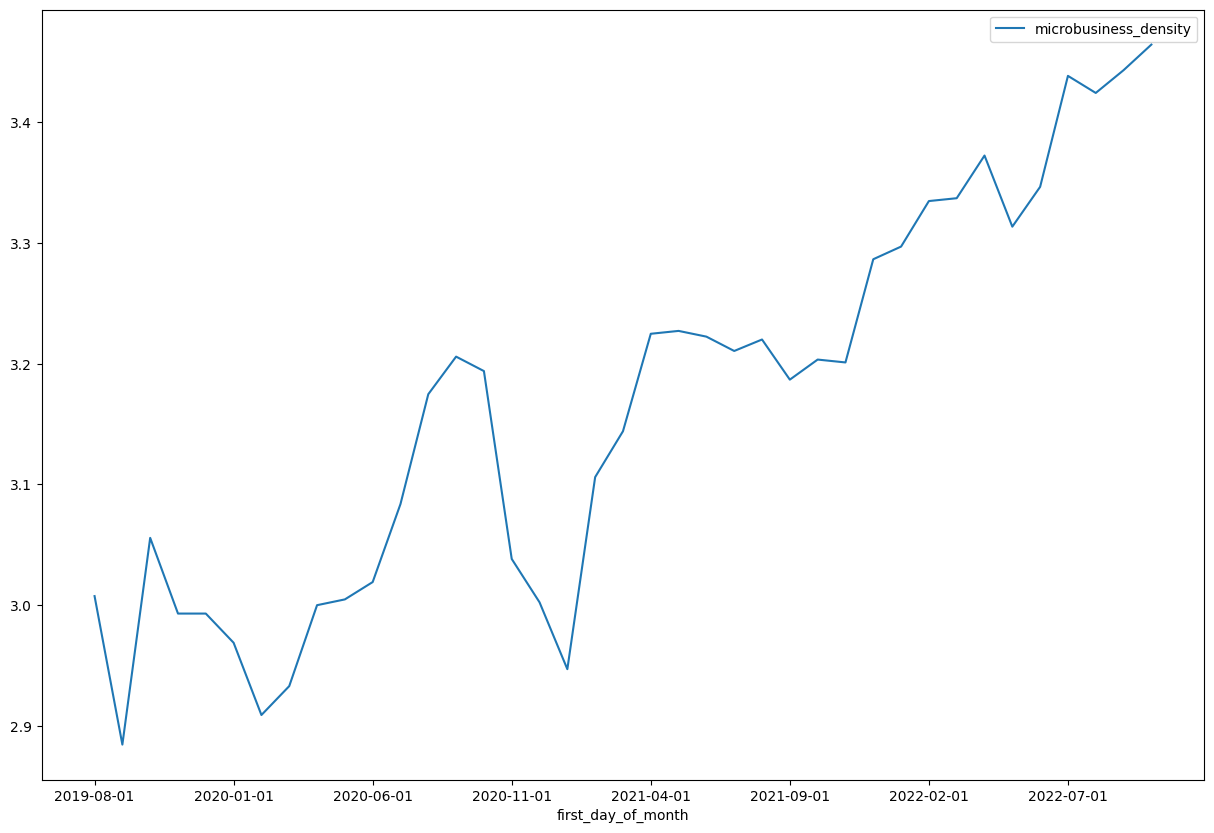

In [15]:
ax = ts.plot(x='first_day_of_month', y='microbusiness_density', figsize=(15, 10))

In [16]:
ts['lag_1'] = ts['microbusiness_density'].shift(1)
ts = ts.rename(columns={'microbusiness_density': 'target'})
ts = ts[['first_day_of_month', 'lag_1', 'target']]
ts

,first_day_of_month,lag_1,target
141,2019-08-01,NaN,3.007682
142,2019-09-01,3.007682,2.884870
143,2019-10-01,2.884870,3.055843
144,2019-11-01,3.055843,2.993233
145,2019-12-01,2.993233,2.993233
146,2020-01-01,2.993233,2.969090
147,2020-02-01,2.969090,2.909326
148,2020-03-01,2.909326,2.933231
149,2020-04-01,2.933231,3.000167
150,2020-05-01,3.000167,3.004948


In [17]:
for lag in range(1, 6):
    print('Creating lag{}'.format(lag))
    ts['lag_{}'.format(lag)] = ts['target'].shift(lag)

Creating lag1
Creating lag2
Creating lag3
Creating lag4
Creating lag5


In [18]:
ts = ts[['first_day_of_month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'target']]
ts

,first_day_of_month,lag_1,lag_2,lag_3,lag_4,lag_5,target
141,2019-08-01,NaN,NaN,NaN,NaN,NaN,3.007682
142,2019-09-01,3.007682,NaN,NaN,NaN,NaN,2.884870
143,2019-10-01,2.884870,3.007682,NaN,NaN,NaN,3.055843
144,2019-11-01,3.055843,2.884870,3.007682,NaN,NaN,2.993233
145,2019-12-01,2.993233,3.055843,2.884870,3.007682,NaN,2.993233
146,2020-01-01,2.993233,2.993233,3.055843,2.884870,3.007682,2.969090
147,2020-02-01,2.969090,2.993233,2.993233,3.055843,2.884870,2.909326
148,2020-03-01,2.909326,2.969090,2.993233,2.993233,3.055843,2.933231
149,2020-04-01,2.933231,2.909326,2.969090,2.993233,2.993233,3.000167
150,2020-05-01,3.000167,2.933231,2.909326,2.969090,2.993233,3.004948


<AxesSubplot: xlabel='first_day_of_month'>

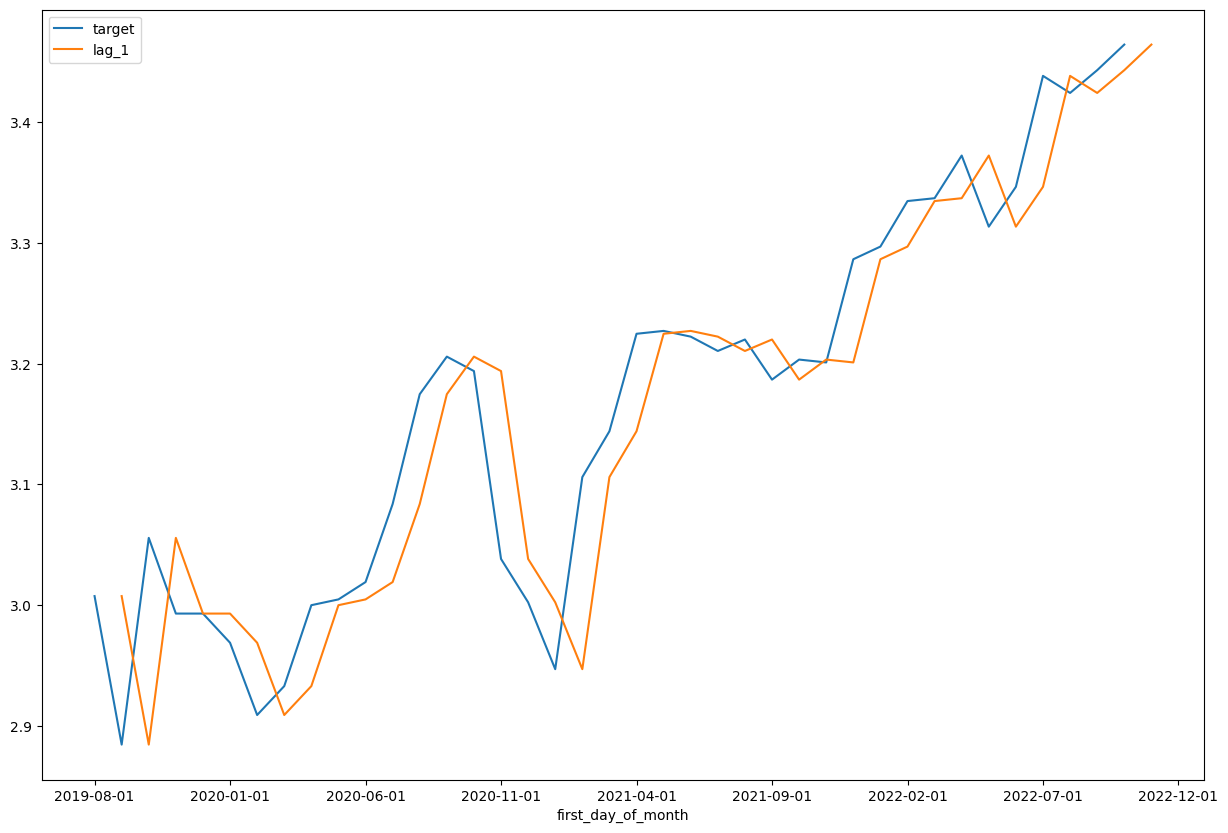

In [19]:
ax = ts.plot(x='first_day_of_month', y='target', figsize=(15, 10))
ts.plot(x='first_day_of_month', y='lag_1', figsize=(15, 10), ax = ax)


In [25]:
# ts_2 = raw.loc[(raw['cfips'] == 1001) | (raw['cfips'] == 1007), ['cfips', 'dcount','first_day_of_month', 'microbusiness_density']]
ts_2 = raw[['cfips',
            # 'dcount',
            'first_day_of_month', 'istest', 'microbusiness_density']]
ts_2

,cfips,first_day_of_month,istest,microbusiness_density
0,10001,2019-08-01,0,4.995701
1,10001,2019-09-01,0,5.031902
2,10001,2019-10-01,0,5.098270
3,10001,2019-11-01,0,5.124666
4,10001,2019-12-01,0,5.086203
...,...,...,...,...
147340,9015,2023-02-01,1,NaN
147341,9015,2023-03-01,1,NaN
147342,9015,2023-04-01,1,NaN
147343,9015,2023-05-01,1,NaN


In [26]:
ts_2 = ts_2.rename(columns={'microbusiness_density': 'target'})

In [27]:
ts_2['lag_1'] = ts_2.groupby('cfips')['target'].shift().bfill()
ts_2

,cfips,first_day_of_month,istest,target,lag_1
0,10001,2019-08-01,0,4.995701,4.995701
1,10001,2019-09-01,0,5.031902,4.995701
2,10001,2019-10-01,0,5.098270,5.031902
3,10001,2019-11-01,0,5.124666,5.098270
4,10001,2019-12-01,0,5.086203,5.124666
...,...,...,...,...,...
147340,9015,2023-02-01,1,NaN,NaN
147341,9015,2023-03-01,1,NaN,NaN
147342,9015,2023-04-01,1,NaN,NaN
147343,9015,2023-05-01,1,NaN,NaN


In [28]:
lag_features = []
for lag in range(1, 10):
    lag_feat_name = 'lag_{}'.format(lag)
    ts_2[lag_feat_name] = ts_2.groupby('cfips')['target'].shift(lag).bfill()
    lag_features.append(lag_feat_name)

In [29]:
ts_2

,cfips,first_day_of_month,istest,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
0,10001,2019-08-01,0,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701
1,10001,2019-09-01,0,5.031902,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701
2,10001,2019-10-01,0,5.098270,5.031902,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701
3,10001,2019-11-01,0,5.124666,5.098270,5.031902,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701
4,10001,2019-12-01,0,5.086203,5.124666,5.098270,5.031902,4.995701,4.995701,4.995701,4.995701,4.995701,4.995701
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,9015,2023-02-01,1,NaN,NaN,NaN,NaN,3.566885,3.567954,3.552985,3.574369,3.521978,3.524116
147341,9015,2023-03-01,1,NaN,NaN,NaN,NaN,NaN,3.566885,3.567954,3.552985,3.574369,3.521978
147342,9015,2023-04-01,1,NaN,NaN,NaN,NaN,NaN,NaN,3.566885,3.567954,3.552985,3.574369
147343,9015,2023-05-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.566885,3.567954,3.552985


In [30]:

for step in range(8):
    # 1; Выбираем нужные признаки
    # 2. Обучаем на них модель (RandomForestRegressor)
    # 3. Выбираем текущую строку тестовых данных
    # 4. Делаем на ней прогноз
    print('step == {}'.format(step))

    features = []
    for lag_col in lag_features:
        lag = int(lag_col.split('_')[-1])
        # Feature for our current model
        if lag >= (step+1):
            features.append(lag_col)

    train_X = ts_2.loc[ts_2['istest'] == 0, features]
    train_y = ts_2.loc[ts_2['istest'] == 0, 'target']

    test_X = ts_2.loc[(ts_2['istest'] == 1) & (ts_2['dcount'] == step),  features]


    model = RandomForestRegressor(random_state=42, n_jobs=-1)

    model.fit(train_X, train_y)

    preds = model.predict(test_X)


    print(features)



step == 0


KeyError: 'dcount'

### Feature engineering

In [ ]:
def build_features(df):

    for lag in range(1, 10):
        df[f'mbd_lag_{lag}'] = df.groupby('cfips')['microbusiness_density'].shift(lag)
        df[f'act_lag_{lag}'] = df.groupby('cfips')['active'].shift(lag)
        df[f'mbd_lag_{lag}'] = df.groupby('cfips')[f'mbd_lag_{lag}'].bfill()
        df[f'act_lag_{lag}'] = df.groupby('cfips')[f'act_lag_{lag}'].bfill()

    return df
    
raw = build_features(raw)
gc.collect()
raw.tail(20)

In [ ]:
raw.iloc[-20:,:20]

### SMAPE

In [ ]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))

    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]

    return 100 * np.mean(smap)

print( smape( np.array([0, 0]),  np.array([0, 0]) ) )
print( smape( np.array([0, 0]),  np.array([0, 1]) ) )
print( smape( np.array([0, 0]),  np.array([1, 0]) ) )
print( smape( np.array([0, 0]),  np.array([1, 1]) ) )


In [ ]:
LAG_FEATURES = list(raw.columns[13:]) 
print(LAG_FEATURES)

In [ ]:
test['first_day_of_month'].value_counts()

In [ ]:

for step in tqdm(range(8)):
    #print(step)

    features = []
    for f in LAG_FEATURES:
        lag = int(f.split('_')[-1])
        if lag >= (step+1):
            features.append(f)

    model = RandomForestRegressor(n_jobs=-1)

    train_indices = (raw.istest==0)
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'microbusiness_density'],
    )

    test_indices = (raw.istest==1) & (raw.dcount == step)
    raw.loc[test_indices, 'microbusiness_density'] = model.predict(raw.loc[test_indices, features])
    print()

In [ ]:
ax = raw.loc[(raw.cfips==10001)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density');
raw.loc[(raw.cfips==10001)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density');

In [ ]:
ax = raw.loc[(raw.cfips==10003)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==10003)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

In [ ]:
ax = raw.loc[(raw.cfips==9011)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9011)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

In [ ]:
ax = raw.loc[(raw.cfips==9013)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9013)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

In [ ]:
ax = raw.loc[(raw.cfips==9015)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9015)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

In [ ]:
test = raw.loc[raw.istest==1, ['row_id', 'microbusiness_density']].copy()
test.to_csv('submission.csv', index=False)
test.head(40)